In [1]:
### init & user input
## user input
select_from_build = True
check_consistency = False

## packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## importing
directory = './data/'
appendix = '1k_phonons'
if select_from_build == False and appendix != '':
  hits = f"{directory}hits_{appendix}.csv"
  primaries = f"{directory}primaries_{appendix}.csv"
  volume_hits = f"{directory}deposits_{appendix}.csv"
  print('directory: ', "./analysis/data/")
  print('with appendix: ', appendix)
else:
  directory = '../build/'
  hits = f"{directory}hits.csv"
  primaries = f"{directory}primaries.csv"
  deposits = f"{directory}deposits.csv"
  print('directory: ', "./build/")

# hits format
# run, event, track, type, e_i, x_i, y_i, z_i, t_i, e_dep, x_f, y_f, z_f, t_f
hits = pd.read_csv(hits, sep=',')
# primaries format
# run, event, type, e_i, x_i, y_i, z_i, t_i
primaries = pd.read_csv(primaries, sep=',')
# deposits format
# run, event, track, type, volume, e_i, x_i, y_i, z_i, t_i, e_dep, x_f, y_f, z_f, t_f
deposits = pd.read_csv(deposits, sep=',')
# note: units are in eV, mm, ns

hits['id'] = '(' + hits['run'].astype(str) + ',' + hits['event'].astype(str) + ',' + hits['track'].astype(str) + ')'
primaries['id'] = '(' + primaries['run'].astype(str) + ',' + primaries['event'].astype(str) + ')'
deposits['id'] = '(' + deposits['run'].astype(str) + ',' + deposits['event'].astype(str) + ',' + deposits['track'].astype(str) + ')'
# remove run, event, track
hits = hits.drop(columns=['run', 'event', 'track'])
primaries = primaries.drop(columns=['run', 'event'])
deposits = deposits.drop(columns=['run', 'event', 'track'])

# shorten `type` names
hits['type'] = hits['type'].replace({"phononTS": 'TS', "phononTF": 'TF'})
primaries['type'] = primaries['type'].replace({"phononTS": 'TS', "phononTF": 'TF'})
deposits['type'] = deposits['type'].replace({"phononTS": 'TS', "phononTF": 'TF'})
                
# convert to meV
hits['e_i'] = hits['e_i']*1e3
hits['e_dep'] = hits['e_dep']*1e3
primaries['e_i'] = primaries['e_i']*1e3
deposits['e_i'] = deposits['e_i']*1e3
deposits['e_dep'] = deposits['e_dep']*1e3

hits.head()

directory:  ./build/


,type,volume,e_i,x_i,y_i,z_i,t_i,e_dep,x_f,y_f,z_f,t_f,id
0,TF,World,4.33735,-29.0458,9.41274,-0.081524,1517.03,0.00000,-25.7103,12.99220,0.5,41929.30,"(0,0,15)"
1,TS,World,7.21975,-29.0458,9.41274,-0.081524,1517.03,7.21975,-26.2776,9.15696,-0.5,9210.24,"(0,0,14)"
2,TS,kid_cap24,4.29315,-29.0020,8.20365,0.157121,4176.16,4.29315,-30.3243,5.95459,0.5,35206.90,"(0,0,17)"
3,TS,kid_ind45,4.38489,-29.0020,8.20365,0.157121,4176.16,4.38489,-24.1046,-5.52872,0.5,26150.30,"(0,0,16)"
4,TS,World,2.85951,-27.9710,8.80252,-0.105788,1269.91,0.00000,-17.9325,17.48520,-0.5,43703.40,"(0,0,25)"


In [24]:
### sanity checks & basic statistics

# numbers
print('#Terminations:\t\t\t\t', len(hits))
print('#Primaries:\t\t\t', len(primaries))
print('#Hits/Primary:\t\t\t', round(len(hits) / len(primaries), 2), '\n')

## validate the data
# check for duplicate ids
hits_unique = len(hits['id']) == len(hits['id'].unique())
primaries_unique = len(primaries['id']) == len(primaries['id'].unique())
deposits_unique = len(deposits['id']) == len(deposits['id'].unique())
print('`id` unique?:\t\t\t', hits_unique and primaries_unique and deposits_unique)
# check consistency
if check_consistency:
  flag_consistent = True
  for id, deposit in deposits.groupby('id'):
    hit = hits[hits['id'] == id]
    # e_i, x_i, y_i, z_i, t_i, e_dep, x_f, y_f, z_f, t_f
    e_cosistent = np.isclose(hit['e_i'].values, deposit['e_i'].values) and np.isclose(hit['e_dep'].values, deposit['e_dep'].values)
    x_cosistent = np.isclose(hit['x_i'].values, deposit['x_i'].values) and np.isclose(hit['x_f'].values, deposit['x_f'].values)
    y_cosistent = np.isclose(hit['y_i'].values, deposit['y_i'].values) and np.isclose(hit['y_f'].values, deposit['y_f'].values)
    z_cosistent = np.isclose(hit['z_i'].values, deposit['z_i'].values) and np.isclose(hit['z_f'].values, deposit['z_f'].values)
    t_cosistent = np.isclose(hit['t_i'].values, deposit['t_i'].values) and np.isclose(hit['t_f'].values, deposit['t_f'].values)
    if not e_cosistent or not x_cosistent or not y_cosistent or not z_cosistent or not t_cosistent:
      print('Inconsistent data:', id)
      flag_consistent = False
  print(f"consistency check:\t\t", f"{flag_consistent}\n")

## basic statistics
energy_deposited = hits['e_dep'].sum()
energy_initial = primaries['e_i'].sum()
energy_missing = hits[hits['e_dep'] == 0]['e_i'].sum()

print('Initial energy:\t\t\t', round(energy_initial, 2), 'meV')
print('Energy deposited:\t\t', round(energy_deposited, 2), 'meV')
print('Energy not deposited:\t\t', round(energy_missing, 2), 'meV')
print('Energy change:\t\t\t+', round(energy_deposited - energy_initial, 20), 'meV')
print('With missed energy:\t\t+', round(energy_deposited + energy_missing - energy_initial, 20), 'meV', '\n')

# print the minimum/maximums of each dimension
print('Minimums:')
print("x [mm]:\t\t", hits['x_f'].min())
print("y [mm]:\t\t", hits['y_f'].min())
print("z [mm]:\t\t", hits['z_f'].min())
print("t [mus]:\t", hits['t_f'].min())
print("e_i [meV]:\t", hits['e_i'].min(), '\n')
print("e_dep [meV]:\t", hits['e_dep'].min(), '\n')
print('Maximums:')
print("x [mm]:\t\t", hits['x_f'].max())
print("y [mm]:\t\t", hits['y_f'].max())
print("z [mm]:\t\t", hits['z_f'].max())
print("t [mus]:\t", hits['t_f'].max())
print("e_i [meV]:\t", hits['e_i'].max())
print("e_dep [meV]:\t", hits['e_dep'].max(), '\n')


#Terminations:				 54426142
#Primaries:			 100000
#Hits/Primary:			 544.26 

`id` unique?:			 True
Initial energy:			 220000000.0 meV
Energy deposited:		 179385419.36 meV
Energy not deposited:		 40614563.0 meV
Energy change:			+ -40614580.64413723 meV
With missed energy:		+ -17.643042385578156 meV 

Minimums:
x [mm]:		 -38.5
y [mm]:		 -38.5
z [mm]:		 -0.5
t [mus]:	 0.0159205
e_i [meV]:	 0.012267799999999999 

e_dep [meV]:	 0.0 

Maximums:
x [mm]:		 38.5
y [mm]:		 38.5
z [mm]:		 0.5
t [mus]:	 207754.0
e_i [meV]:	 111.35000000000001 

e_dep [meV]:	 111.35000000000001 



#Primaries: 100000
#Terminations: 54426142
#Deposits: 42229796 



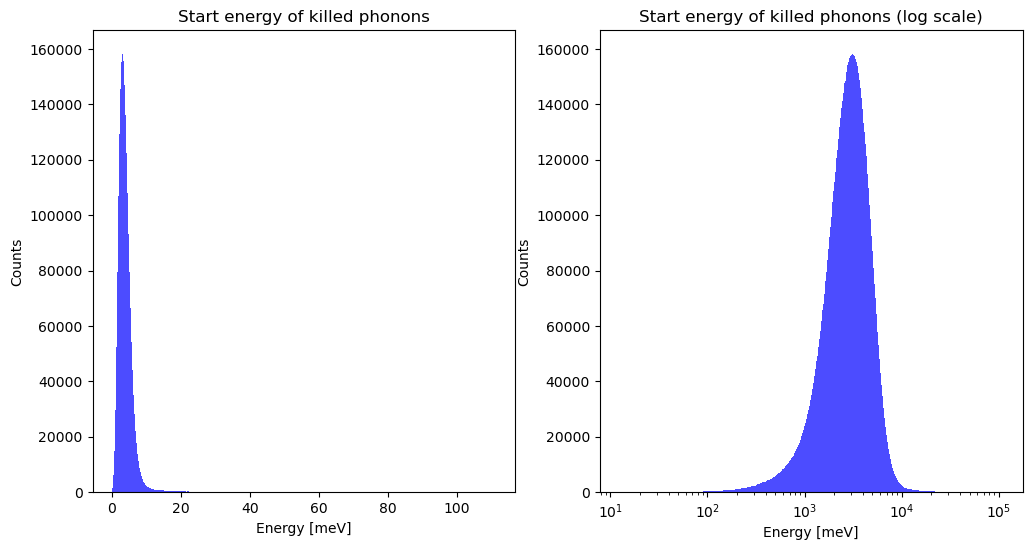

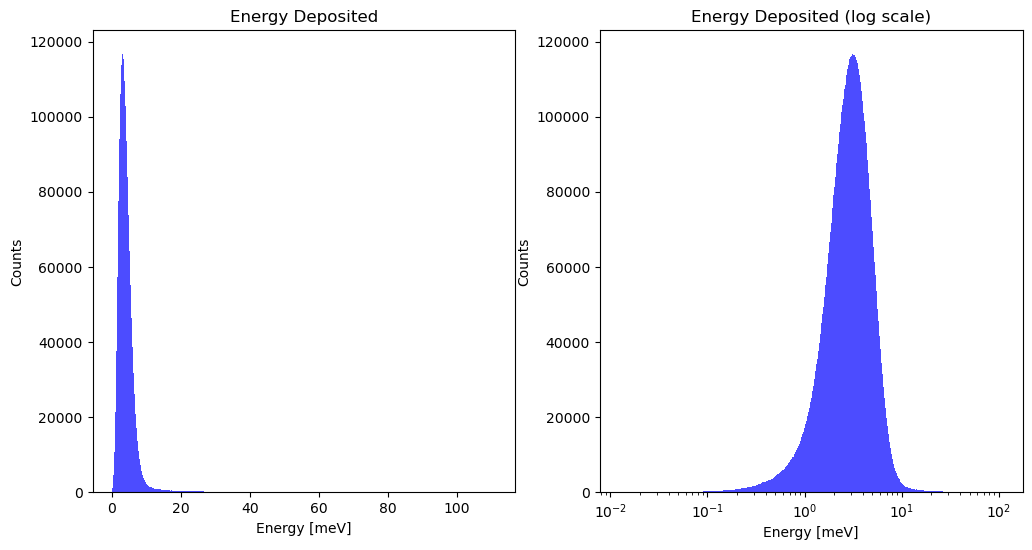

In [25]:
# do histogram of counts vs energy
bins=10000

# print counts
print('#Primaries:', len(primaries))
print('#Terminations:', len(hits))
print('#Deposits:', len(deposits), '\n')

# two plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# plot 1
axs[0].hist(hits['e_i'], bins=bins, color='blue', alpha=0.7)
axs[0].set_title('Start energy of killed phonons')
axs[0].set_xlabel('Energy [meV]')
axs[0].set_ylabel('Counts')
# plot 2
axs[1].hist(hits['e_i']*1000, bins=bins, color='blue', alpha=0.7)
axs[1].set_title('Start energy of killed phonons (log scale)')
axs[1].set_xlabel('Energy [meV]')
axs[1].set_ylabel('Counts')
plt.xscale('log')
plt.show()

# now only energy depositions > 0
# plot
# two plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# plot 1
axs[0].hist(deposits['e_dep'], bins=bins, color='blue', alpha=0.7)
axs[0].set_title('Energy Deposited')
axs[0].set_xlabel('Energy [meV]')
axs[0].set_ylabel('Counts')
# plot 2
axs[1].hist(deposits['e_dep'], bins=bins, color='blue', alpha=0.7)
axs[1].set_title('Energy Deposited (log scale)')
axs[1].set_xlabel('Energy [meV]')
axs[1].set_ylabel('Counts')
plt.xscale('log')
plt.show()

/tmp/ipykernel_183097/1751607108.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_grouped = hits.groupby('time_bin')['e_dep'].sum() / len(primaries)


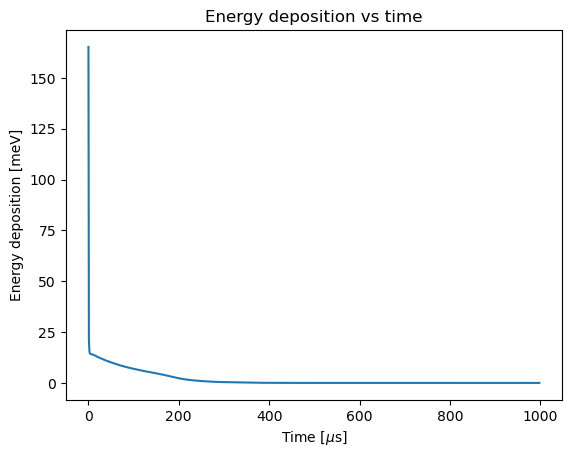

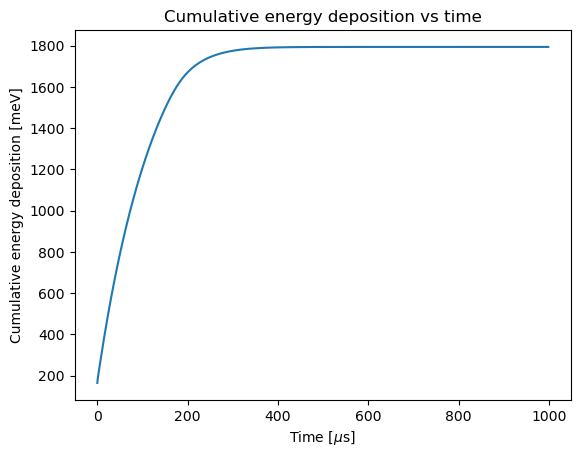

In [26]:
# plot energy deposition vs time
# bin the time values into 1000 bins
time_bins = np.linspace(0, hits['t_f'].max(), 1000)
hits['time_bin'] = pd.cut(hits['t_f'], time_bins)

# group by time bin and sum energy deposition and divide by number of primaries
time_grouped = hits.groupby('time_bin')['e_dep'].sum() / len(primaries)
time_grouped.plot()
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Energy deposition [meV]')
plt.title('Energy deposition vs time')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
plt.show()

# same thing but cumulative
time_grouped.cumsum().plot()
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Cumulative energy deposition [meV]')
plt.title('Cumulative energy deposition vs time')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
plt.show()


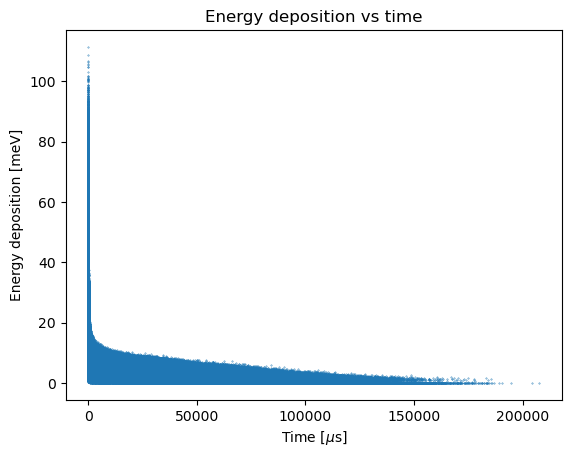

In [27]:
# scatter plot of time vs energy deposition
time = hits['t_f']
energy = hits['e_dep']
plt.scatter(time, energy, s=0.1)
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Energy deposition [meV]')
plt.title('Energy deposition vs time')
# plt.yscale('log')
plt.show()



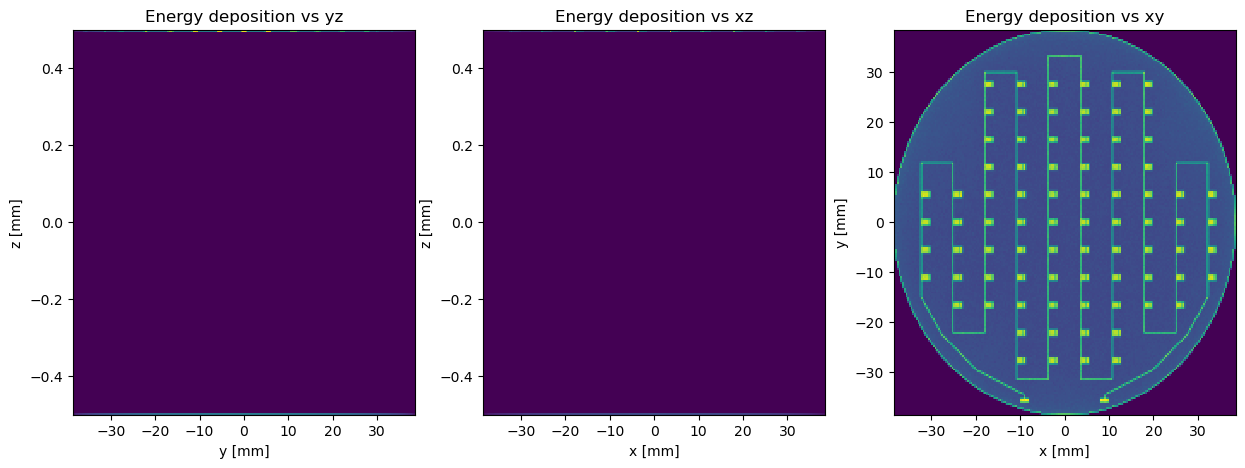

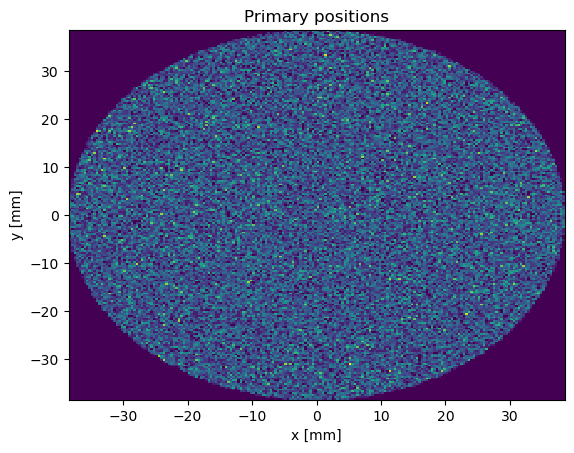

In [28]:
# hit projections
bins = 200
bins_secondary = 10
# bin in x, y, z
# hits['x_bin'] = pd.cut(hits['x_f'], bins)
# hits['y_bin'] = pd.cut(hits['y_f'], bins)
# hits['z_bin'] = pd.cut(hits['z_f'], bins_secondary)

## 2d histogram
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# grid lines with bin
for axis in axes:
  index = axes.tolist().index(axis)
  dim = ['yz', 'xz', 'xy'][index]
  axis.set_xlabel(f'{dim[0]} [mm]')
  axis.set_ylabel(f'{dim[1]} [mm]')
  axis.set_title(f'Energy deposition vs {dim}')
  axis.hist2d(hits[f'{dim[0]}_f'], hits[f'{dim[1]}_f'], bins=bins)
  
  if dim == 'xy':
    # plot primary positions
    # axis.scatter(primaries['x_i'], primaries['y_i'], c='w', s=0.1)
    pass
plt.show()

## plot primary positions in xy
plt.hist2d(primaries['x_i'], primaries['y_i'], bins=bins)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Primary positions')
plt.show()


Kid 2
Energy deposited:			 220835.27 meV
Initial energy of captured phonons:	 227658.49 meV
Energy efficiency:			 0.97%
Counts:					 59514 

Average x position of hits:
 x_f    -2.586114
y_f    27.611799
z_f     0.500000
dtype: float64


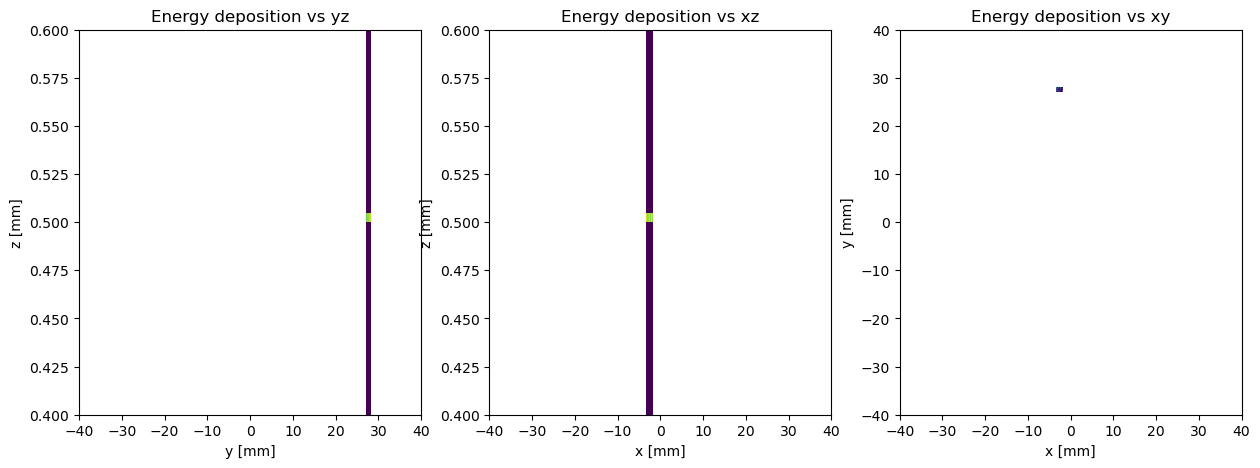

/tmp/ipykernel_183097/3932359669.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_grouped = kid_hits.groupby('time_bin')['e_dep'].sum() / len(primaries)


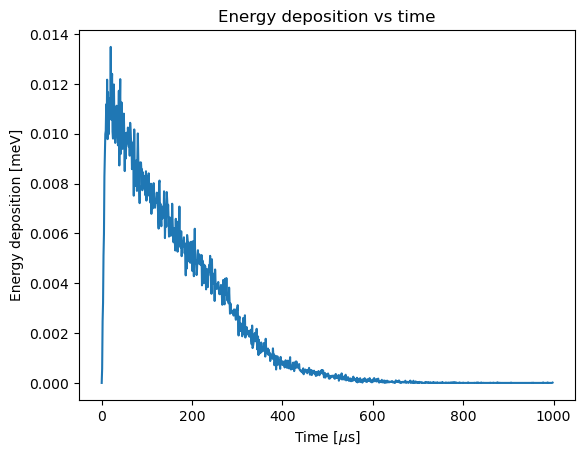

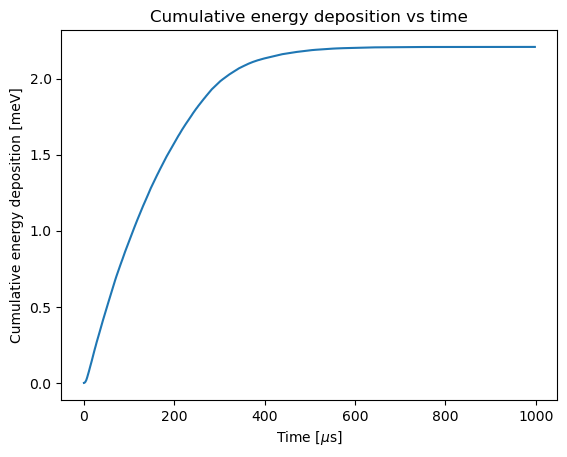

In [57]:
### single kid analysis
## user input
kid_index = 2
bins = 200
bins_secondary = 10

## helpers
def get_kid_hits(kid_index):
  # there are two relevant volumes, the inductor and the capacitor or: "kid_ind{index}" and "kid_cap{index}"
  kid_hits = hits[hits['volume'].str.contains(f"ind{kid_index}|cap{kid_index}")]
  # we also have to make sure `2` is not confused with `20` etc.
  kid_hits = kid_hits[kid_hits['volume'].str.endswith(f"{kid_index}")]
  # do one more pass to make sure `22` is not confused with `2`
  kid_hits = kid_hits[~kid_hits['volume'].str.endswith(f"{kid_index}{kid_index}")]
  return kid_hits

kid_hits = get_kid_hits(kid_index)
## basic statistics
energy_deposited = kid_hits['e_dep'].sum()
energy_initial = kid_hits['e_i'].sum()
energy_efficiency = energy_deposited / energy_initial
count = len(kid_hits)
average_position = kid_hits[['x_f', 'y_f', 'z_f']].mean()
print('Kid', kid_index)
print('Energy deposited:\t\t\t', round(energy_deposited, 2), 'meV')
print('Initial energy of captured phonons:\t', round(energy_initial, 2), 'meV')
print('Energy efficiency:\t\t\t', f"{round(energy_efficiency, 2)}%")
print('Counts:\t\t\t\t\t', count, '\n')
print('Average x position of hits:\n', average_position)

## 2d histogram
if (True):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  # grid lines with bin
  for axis in axes:
    index = axes.tolist().index(axis)
    dim = ['yz', 'xz', 'xy'][index]
    axis.set_xlabel(f'{dim[0]} [mm]')
    axis.set_ylabel(f'{dim[1]} [mm]')
    axis.set_title(f'Energy deposition vs {dim}')
    axis.hist2d(kid_hits[f'{dim[0]}_f'], kid_hits[f'{dim[1]}_f'], bins=bins)
    # zoom out
    axis.set_xlim(-40, 40)
    if index == 2:
      axis.set_ylim(-40,40)
    else:
      axis.set_ylim(0.4, 0.6)
  plt.show()

## plot energy deposition vs time
# bin the time values into 1000 bins
time_bins = np.linspace(0, kid_hits['t_f'].max(), 1000)
kid_hits['time_bin'] = pd.cut(kid_hits['t_f'], time_bins)

# group by time bin and sum energy deposition and divide by number of primaries
time_grouped = kid_hits.groupby('time_bin')['e_dep'].sum() / len(primaries)
time_grouped.plot()
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Energy deposition [meV]')
plt.title(f'Energy deposition vs time for kid {kid_index}')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
plt.show()

# same thing but cumulative
time_grouped.cumsum().plot()
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Cumulative energy deposition [meV]')
plt.title(f'Cumulative energy deposition vs time for kid {kid_index}')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
plt.show()